# Credit Card Approval mit Machine Learning
WWI20DSA; Semester-4;  <br>
Chengyi Hua (8883221); Yassir Knierim (7362794); Jan Rüdt (1737304)

## Projektbeschreibung
Das Kredit-Scoring ist eine weit verbreitete Methode des Risikomanagements im Finanzsektor. Es verwendet persönliche Informationen und Daten, die von Kreditkartenantragstellern bereitgestellt werden, um zukünftige Insolvenzen und Kreditkartendarlehen abzuschätzen. Die Bank ist befugt zu entscheiden, ob sie dem Antragsteller eine Kreditkarte zur Verfügung stellt oder nicht. Kredit-Scores können das Risikoniveau objektiv einschätzen. Ein maschinelles Lernmodell ist erforderlich, um vorherzusagen, ob eine Anwendung in diesem Datensatz ein „guter“ oder „schlechter“ Benutzer ist. Durch unsere Zielvariable oder Definition soll sie vorhersagen, ob der Benutzer als Risikobenutzer eingestuft wird oder nicht.
<br>
<br>

## Ziel:
![](confusionM.png) <br>
In diesem Projekt werden risikobehaftete Kunden als 1 und risikofreie als 0 definiert. Dabei wird es wichtig sein den Fehler Typ II soweit wie möglich zu vermeiden. In diesem Fall bedeutet Fehler Type II, dass Kunden eine credit card approval bekommen würden, obwohl sie als risikobehaftet erkannt werden sollte.
<br><br>

theorie: Confusions Matrix und Fehler Type I und II <br>
 
Hürden: <br>
-  Das Problem der unausgeglichenen Daten ist ein wesentliches Problem in diesem Projekt.<br>
Mögliche Lösung: Verwenden Sie das Paket PyCaret, um den unausgeglichenen Datensatz zu reparieren
-  Experimente mit verschiedene Modelle. Schnelleres Vorgehen mit __PyCaret__ möglich
-  Down- oder Oversampling

### Definition der Parameter
| Attribut Bezeichnung | Beschreibung | Kommentar |
| ------------ | ----------- | ------- |
|applicant_ID| Kundennummer |Für das Modell nicht relevant |	
|gender|	Geschlecht|Kategorial	|
|owning_car|	Autobesitz	|Kategorial |
|owning_property|	Immobilienbesitz	|Kategorial |
|children_amt|	Anzahl von Kindern|Numerisch |	
|anual_income|	Jährliches Einkommen|Numerisch |	
|education_level|	Bildungsniveau	|Kategorial |
|marital_status|	Familienstand	|Kategorial |
|housing_type|	Wohnsituation	|Kategorial |
|age|Alter |Numerisch |
|working_years|	Arbeitsdauer in Jahren|Numerisch |	
|owning_phone|	Handybesitz	|Kategorial |
|owning_work_phone|	Arbeitshandybesitz	|Kategorial |
|owning_email|	Emailbesitz	|Kategorial |
|job|Arbeitstitel|Kategorial |
|payment_status|	Status|1: 1–29 Tage überfällig<br> 2: 30–59 Tage überfällig<br> 3: 60–89 Tage überfällig<br> 4: 90–119 Tage überfällig<br> 5: 120–149 Tage überfällig<br> 6: Überfällig oder uneinbringlich, Abschreibungen für mehr als 150 Tage<br> -1: in diesem Monat abbezahlt<br> 0: kein Darlehen für den Monat. Kategorial|
|risk_user|	Ziel|	Risikonutzer sind mit „1“ gekennzeichnet, ansonsten mit „0“. Kategorial|

Tabelle (1)<br>
@Dennis Knierim

In [4]:
categorical_features = []

## Loading dependencies

In [1]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import missingno as mso
import seaborn as sns
import warnings
import pycaret
import math
from collections import Counter
from numpy.random import default_rng
from imblearn.under_sampling import *
import imblearn
from sklearn.model_selection import KFold
from pycaret.classification import *

# --- Libraries Settings ---
#warnings.filterwarnings('ignore')
#plt.rcParams['figure.dpi'] = 100

## Datenanpassung

In [2]:
cca =  pd.read_csv('credit_card_approval.csv')
# rough years of employment
cca.DAYS_EMPLOYED = abs(cca.DAYS_EMPLOYED) // 365
# finding out each customers age
cca.DAYS_BIRTH =  abs(cca.DAYS_BIRTH) // 365  
cca.AMT_INCOME_TOTAL = pd.to_numeric(cca.AMT_INCOME_TOTAL)
# dropping unneccessary attributes
cca = cca.drop("FLAG_MOBIL", axis=1)



cca.rename(columns = {'CODE_GENDER':'gender', 
                      'DAYS_BIRTH': 'age',
                      'DAYS_EMPLOYED': 'working_years',
                      'FLAG_OWN_CAR':'owning_car',
                      'FLAG_OWN_REALTY': 'owning_property',
                      'CNT_CHILDREN': 'children_amt',
                      'AMT_INCOME_TOTAL': 'anual_income',
                      'NAME_EDUCATION_TYPE': 'education_level',
                      'NAME_FAMILY_STATUS': 'marital_status',
                      'NAME_HOUSING_TYPE': 'housing_type',
                      'FLAG_WORK_PHONE': 'owning_work_phone',
                      'FLAG_EMAIL': 'owning_email',
                      'FLAG_PHONE': 'owning_phone',
                      'STATUS': 'payment_status',
                      'TARGET': 'risk_user',
                      'JOB': 'job',
                      'ID': 'applicant_ID'
                      }, inplace = True)


cca["owning_car"].replace({'Y' : '1', 'N': '0'}, inplace= True)
cca["risk_user"].replace({1: 'Y', 0: 'N' }, inplace= True)
cca["owning_property"].replace({'Y' : '1', 'N': '0'}, inplace= True)
cca["payment_status"].replace({'0' : '1', 
                               '1': '2', 
                               '2': '3', 
                               '3': '4', 
                               '4': '5', 
                               '5': '6', 
                               'C': '-1', 
                               'X': '0'}, inplace= True)
cca.payment_status = [int(i) for i in cca.payment_status ]
cca = cca.sort_values('applicant_ID')



In [3]:
def get_count_of(applicant_frame,column,credit_type):
    df = applicant_frame
    df[column].replace({0:'no_credit',
        -1:'good',
        1:'good',
        2:'bad',
        3:'bad',
        4:'bad',
        5:'bad',
        6:'bad'}, inplace=True)
    values = df[column].value_counts()
    try:
        return values[values.index==credit_type][0]
    except:
        return 0

get_count_of(cca[cca.applicant_ID==5008806],'payment_status','good')

14

In [4]:
good_mapping = {i:get_count_of(cca[cca.applicant_ID==i],'payment_status','good') for i in list(cca.applicant_ID.unique())}
bad_mapping = {i:get_count_of(cca[cca.applicant_ID==i],'payment_status','bad') for i in list(cca.applicant_ID.unique())}
no_mapping = {i:get_count_of(cca[cca.applicant_ID==i],'payment_status','no_credit') for i in list(cca.applicant_ID.unique())}

In [6]:
#bad_mapping

In [5]:
cca['total_good_credit'] = cca.applicant_ID.map(good_mapping)
cca['total_bad_credit'] = cca.applicant_ID.map(bad_mapping)
cca['total_no_credit'] = cca.applicant_ID.map(no_mapping)

In [99]:
# checking for datatype of the different attributes
#print(cca.dtypes)

# getting insides into the attribute contents, Check for na and errors
#columns = []
#for n in cca.columns:
#    columns.append(n)

#for n in columns:  
#    print(n)
#    print(cca[n].unique())
#    for i in cca[n].isna():
#        if i == True:
#            print("AHAAAA")
#    print('\n \n')   
#print(cca.isnull().sum())


In [7]:
cca_unique_id = cca.drop_duplicates('applicant_ID')
cca_unique_id.sample(10)

,applicant_ID,gender,owning_car,owning_property,children_amt,anual_income,education_level,marital_status,housing_type,age,...,owning_work_phone,owning_phone,owning_email,job,BEGIN_MONTHS,payment_status,risk_user,total_good_credit,total_bad_credit,total_no_credit
362678,5096748,F,0,1,No children,180000.0,Lower secondary,Widow,House / apartment,46,...,1,1,0,Cleaning staff,-13,-1,N,33,1,0
101082,5022238,F,1,1,1 children,180000.0,Secondary / secondary special,Separated,House / apartment,39,...,0,0,0,Laborers,-17,-1,N,52,0,7
128069,5033569,F,1,0,No children,81000.0,Secondary / secondary special,Married,House / apartment,44,...,1,1,0,Sales staff,-10,-1,N,21,0,3
59496,5113304,M,0,1,1 children,180000.0,Higher education,Married,With parents,42,...,0,0,0,Cooking staff,-20,1,N,22,0,2
399272,5023675,F,0,1,No children,90000.0,Secondary / secondary special,Married,House / apartment,44,...,0,0,0,Cooking staff,0,1,N,3,0,1
255356,5116238,M,0,1,No children,126000.0,Secondary / secondary special,Married,House / apartment,43,...,0,0,0,High skill tech staff,-3,-1,N,48,0,1
61142,5065493,F,0,1,No children,112500.0,Secondary / secondary special,Civil marriage,House / apartment,34,...,1,1,0,Medicine staff,-15,0,N,11,0,2
278647,5068915,F,0,1,1 children,112500.0,Secondary / secondary special,Civil marriage,House / apartment,37,...,0,0,0,Core staff,-17,1,N,11,0,9
321641,5125851,F,0,0,No children,234000.0,Secondary / secondary special,Single / not married,House / apartment,49,...,1,0,0,Cleaning staff,-36,1,N,6,0,1
188792,5009889,M,1,1,No children,270000.0,Secondary / secondary special,Single / not married,House / apartment,36,...,0,0,1,Managers,-14,1,N,15,0,0


## Testdatensatz von 20%
Es wir einen zufälligen Test-Datensatz von 20 Prozent gesampelt. 

---- Theorie.

In [8]:
cca_for_test = cca_unique_id.drop(['BEGIN_MONTHS','payment_status'], axis= 1)
training_data = cca_for_test.sample(frac=0.8, random_state=25)
testing_data = cca_for_test.drop(training_data.index)

## Deskriptive Analyse / Visualisierung 

Die deskriptive Analyse, auch bekannt als deskriptive Analytik oder deskriptive Statistik, ist der Prozess der Verwendung statistischer Techniken zur Beschreibung oder Zusammenfassung einer Reihe von Daten. Als eine der wichtigsten Arten der Datenanalyse ist die deskriptive Analyse beliebt, da sie zugängliche Erkenntnisse aus Daten generieren kann. [1]

Im Gegensatz zu anderen Arten der Datenanalyse versucht die deskriptive Analyse nicht, Vorhersagen über die Zukunft zu treffen. Stattdessen zieht es Erkenntnisse ausschließlich aus vergangenen Daten, indem es sie auf eine Weise manipuliert, die sie aussagekräftiger macht.

@Chengyi Hua

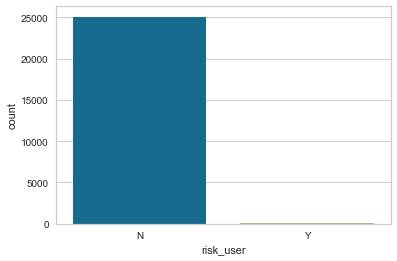

In [9]:
riskuser_plot = sns.countplot(x='risk_user',data=cca_unique_id)

In [10]:
def class_count(y):
    counter = Counter(y)
    for k, v in counter.items():
        dist = v / len(y) * 100
        print(f"Class={k}, n={v} ({dist}%)")

class_count(cca_unique_id.risk_user)

Class=N, n=25062 (99.71353544998807%)
Class=Y, n=72 (0.28646455001193605%)


Unser Datensatz weist weniger als 1% seltener, aber “interessanter” Ereignisse auf (z. B. User, die als ...). Es ist also ein unausgewogener Datensatz. Die meisten Algorithmen zum maschinellen Lernen funktionieren jedoch nicht gut mit unausgewogenen Datensätzen. 

#### Problem mit unausgeglichenem Datensatz <br>
Auswirkung / Folgen: <br>
- __Eine unausgewogene Klassifizierung__. Es für zu der Entwicklung von Vorhersagemodellen für Klassifizierungsdatensätze, die ein schwerwiegendes Klassenungleichgewicht aufweisen. Die Herausforderung bei der Arbeit mit unausgewogenen Datensätzen besteht darin, dass die meisten maschinellen Lerntechniken die Minderheitsklasse ignorieren und dafür eine schlechte Leistung erbringen, obwohl normalerweise die Leistung der Minderheitsklasse am wichtigsten ist.<br><br>




In [11]:
#extracting applicants not being risk user
non_risk_user = cca_unique_id[cca_unique_id.risk_user == 'N']
#not_risk.sample(10)

#extracting applicants being risk user
risk_user = cca_unique_id[cca_unique_id.risk_user == 'Y']
#risk.sample(10)

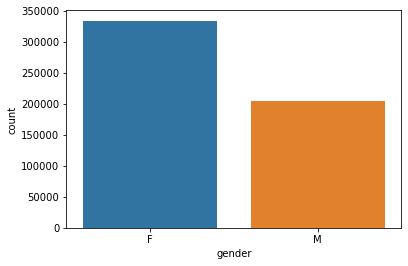

In [28]:
gender_plot = sns.countplot(x='gender',data=cca)


- fig(1): Verteilung von Männern und Frauen in der Tabelle cca. In der Tabelle sind viel mehr Frauen als Männer aufgelistet.

In [34]:
class_count(cca.gender)

Class=F, n=333832 (62.08898816553741%)
Class=M, n=203835 (37.91101183446259%)


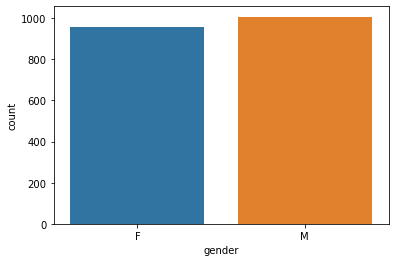

In [8]:
gender_plot_risk = sns.countplot(x='gender',data=risk_user)

- fig(2): Verteilung von Männern und Frauen, die als "Risk User" gekennzeichnet wurden. Männliche Risk User sind etwas häufiger als weibliche Risk User in dieser Tabelle.

In [35]:
class_count(risk_user.gender)

Class=F, n=955 (48.67482161060143%)
Class=M, n=1007 (51.32517838939857%)


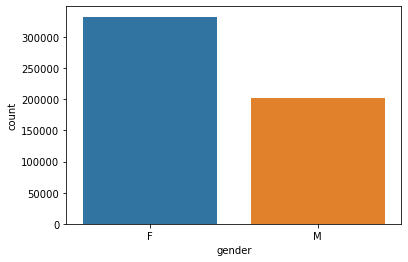

In [9]:
gender_plot_no_risk = sns.countplot(x='gender', data=non_risk_user)

- fig(3): Verteilung von Männern und Frauen, die als Non-Risk User gekennzeichnet wurden. Man sieht dass es deutlich mehr weibliche Non-Risk User gibt als männliche. 
- Ein männlicher User hat eine höhere Wahrscheinlichkeit in dieser Tabelle als Risk-User gekennzeichnet zu sein.

In [36]:
class_count(non_risk_user.gender)

Class=F, n=332877 (62.13811706069572%)
Class=M, n=202828 (37.86188293930428%)


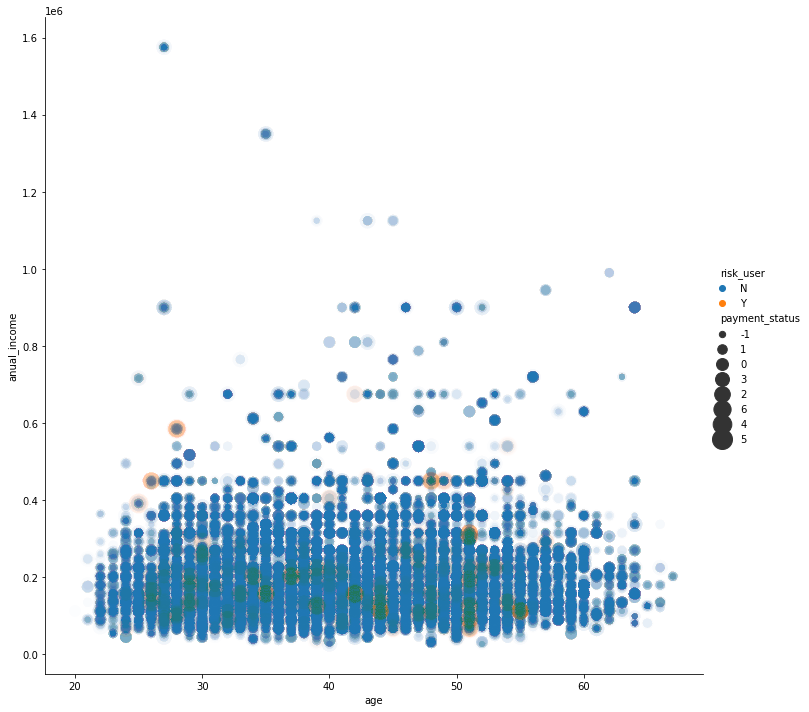

In [10]:
plot_1 = sns.relplot(x='age', y='anual_income', hue='risk_user',size='payment_status',data=cca,
sizes=(400,40),alpha=0.01,height=10)

- fig(4): In dieser Visualisierung versuchen wir eine klare Abtrennung von Risk- und Non-Risk-Unsern darzustellen. Wir plotten dazu die Parameter 'age', 'annual income'  und 'payment status' bei Risk und Non-Risk user. Allerdigns kann keine klare Abtrennung im Scatter-Plot beobachtet werden. Zu sehen ist lediglich, dass die blauen Punkte, die Non-Risk-User darstellen, kleiner sind als die gelben Punkte, die Risk-User darstellen. Man schließt daraus, dass sich lediglich der Parameter 'payment_status' in den beiden Kategorien klar unterscheidet.

@Dennis

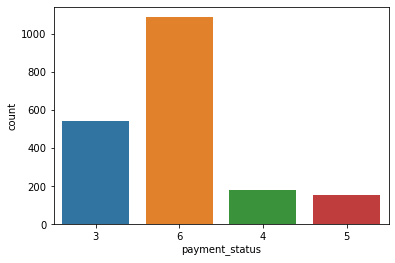

In [11]:
risk_payment_status= sns.countplot(x='payment_status',data=risk_user)

- fig(5): dieser Plot zeigt den 'payment status' aller Risk-User. Es zeichnet sich heraus, dass die meisten Personen in dieser Gruppe einen Zahlungsstatus von 6 haben, also mit ihren Rückzahlungen stark im Verzug sind (siehe Tabelle 1) 

In [37]:
class_count(risk_user.payment_status)

Class=3, n=542 (27.62487257900102%)
Class=6, n=1087 (55.40265035677879%)
Class=4, n=181 (9.225280326197757%)
Class=5, n=152 (7.747196738022426%)


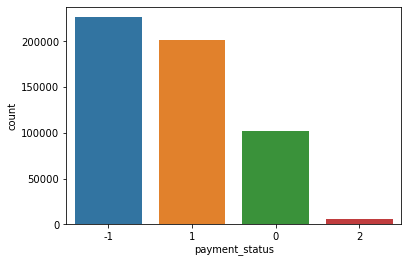

In [12]:
non_risk_payment_status= sns.countplot(x='payment_status', data= non_risk_user)

- fig(6): Dieser Plot zeigt den Zahlungsstatus aller Non-Risk-User. Sie sind mit ihren Rückzahlungen Pünktlich oder nur leicht im Verzug, was einen starken Kontrast zu den Risk-Usern darstellt.

In [38]:
class_count(non_risk_user.payment_status)

Class=-1, n=226185 (42.22193184681868%)
Class=1, n=200930 (37.50758346478006%)
Class=0, n=102167 (19.071503906067704%)
Class=2, n=6423 (1.1989807823335605%)


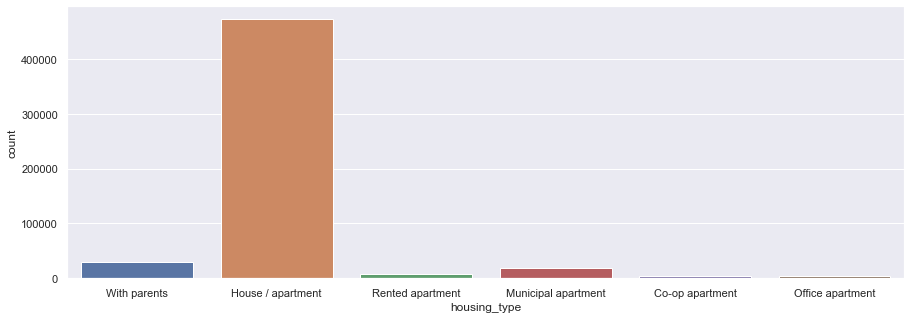

In [87]:
order=list(cca.housing_type.unique())
housing_non_risk = sns.countplot(x='housing_type', data=non_risk_user,order=order)


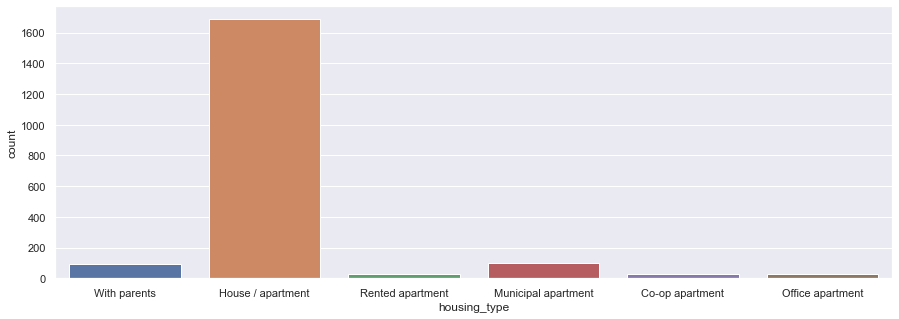

In [88]:
housing_risk = sns.countplot(x='housing_type',data=risk_user,order=order)



Mögliche Lösung für unbalanced Dataset: <br>
- __over sampling__: Ein Ansatz zur Behandlung unausgewogener Datensätze besteht darin, die Minderheitsklasse zu "oversample". Der einfachste Ansatz besteht darin, Beispiele in der Minderheitsklasse zu duplizieren, diese Beispiele gibt dem Modell keine neuen Informationen. Es werden neue Beispiele aus den bestehenden Beispielen synthetisiert. Dies ist eine Art Datenvermehrung für die Minderheitsschicht und wird als Synthetic Minority Oversampling Technique, kurz SMOTE, bezeichnet. <br> <br>
Diese Möglichkeit ist in der PyCarat Bikliothek integriert. Mit __fix_imbalance is True__
, wird der unausgewogene Datensatz angepasst. Auf __Default__ ist der __fit_resample__ Methode auf SMOTE festgelegt.<br> <br>

- __under ampling__: Under-Sampling gleicht den Datensatz aus, indem die Größe der reichlich vorhandenen Klasse reduziert wird. Diese Methode wird verwendet, wenn die Datenmenge ausreicht. Indem alle Stichproben in der seltenen Klasse gehalten werden und zufällig eine gleiche Anzahl von Stichproben in der reichlich vorhandenen Klasse ausgewählt wird, kann ein ausgewogener neuer Datensatz zur weiteren Modellierung abgerufen werden<br><br>
@Chengyi Hua<br> 

## Versuche mit PyCarat <br>

### Gründe für die Benutzung von PyCaret, ein Open-scource ML Bibliothek.

PyCaret ist eine Open-Source-Low-Code-Bibliothek für maschinelles Lernen in Python, die Arbeitsabläufe für maschinelles Lernen automatisiert. Es ist ein End-to-End-Tool für maschinelles Lernen und Modellmanagement, das den Experimentzyklus exponentiell beschleunigt und sie produktiver macht.
<br>
<br>
Verglichen mit den anderen Open-Source-Bibliotheken für maschinelles Lernen ist PyCaret eine alternative Low-Code-Bibliothek, mit der Hunderte von Codezeilen durch nur wenige Zeilen ersetzt werden können. Dies macht Experimente exponentiell schnell und effizient. PyCaret ist im Wesentlichen ein Python-Wrapper um mehrere Bibliotheken und Frameworks für maschinelles Lernen wie scikit-learn, XGBoost, LightGBM, CatBoost, spaCy, Optuna, Hyperopt, Ray und einige mehr.
<br>
<br>
Da immer mehr Unternehmen ihren Fokus auf maschinelles Lernen verlagern, um schwierige Probleme anzugehen, werden von Datenwissenschaftlern erwartet, dass sie schneller Ergebnisse liefern können. Dies hat die Nachfrage nach der Automatisierung wichtiger Phasen in Data-Science-Projekten erhöht, sodass sich Data Scientists auf das eigentliche Problem konzentrieren können, anstatt Hunderte von Codezeilen zu schreiben, um das optimale Modell zu identifizieren.

@Chengyi Hua

theorie tratifiedkfold und kfold unterscheid und verwendung.  im Bezug auf Pycarat

theorie: Cross validierung, weil es hier verwendet wird

## Oversamplingansatz

theorie: SMOTE

In [12]:

stp = pycaret.classification.setup(data = training_data, target = 'risk_user', train_size = 0.8,
            categorical_features = ['gender','owning_car','children_amt', 'owning_property', 'education_level',
                                    'marital_status', 'housing_type', 
                                    'job'], fold_strategy = 'kfold',
            fix_imbalance = True, fix_imbalance_method = imblearn.over_sampling.SMOTE(), fold = 10,
            ignore_features = ['applicant_ID'])

,Description,Value
0,Session id,6749
1,Target,risk_user
2,Target type,Binary
3,Target mapping,"N: 0, Y: 1"
4,Original data shape,"(20107, 18)"
5,Transformed data shape,"(36094, 28)"
6,Transformed train set shape,"(32072, 28)"
7,Transformed test set shape,"(4022, 28)"
8,Ignore features,1
9,Ordinal features,3


In [13]:
best_model_with_oversampling = compare_models(exclude= 'dummy')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.9968,0.9701,0.0000,0.0000,0.0000,-0.0002,-0.0002,1.3690
et,Extra Trees Classifier,0.9968,0.9358,0.0778,0.3000,0.1232,0.1224,0.1516,1.0510
dt,Decision Tree Classifier,0.9948,0.5294,0.0611,0.2000,0.0915,0.0902,0.1074,0.4740
xgboost,Extreme Gradient Boosting,0.9942,0.9428,0.0750,0.1029,0.0454,0.0441,0.0604,1.7660
ada,Ada Boost Classifier,0.9928,0.9155,0.1250,0.2053,0.1040,0.1023,0.1246,1.2020
knn,K Neighbors Classifier,0.9882,0.6789,0.2528,0.0753,0.1124,0.1083,0.1301,0.5990
lightgbm,Light Gradient Boosting Machine,0.9869,0.6993,0.0000,0.0000,0.0000,-0.0016,-0.0026,0.6270
nb,Naive Bayes,0.9769,0.9614,0.7667,0.1007,0.1733,0.1690,0.2652,0.3920
lda,Linear Discriminant Analysis,0.9639,0.9511,0.7250,0.0611,0.1118,0.1068,0.2012,0.5170
ridge,Ridge Classifier,0.9636,0.0000,0.7667,0.0617,0.1131,0.1081,0.2074,0.3720


Processing:   0%|          | 0/45 [00:00<?, ?it/s]

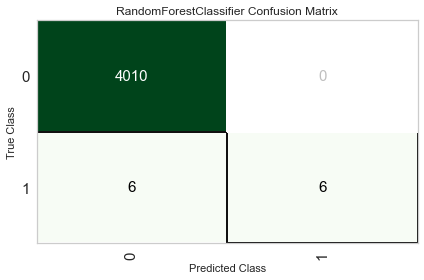

In [20]:
plot_model(best_model_with_oversampling, plot = 'confusion_matrix')

### Erkenntnis


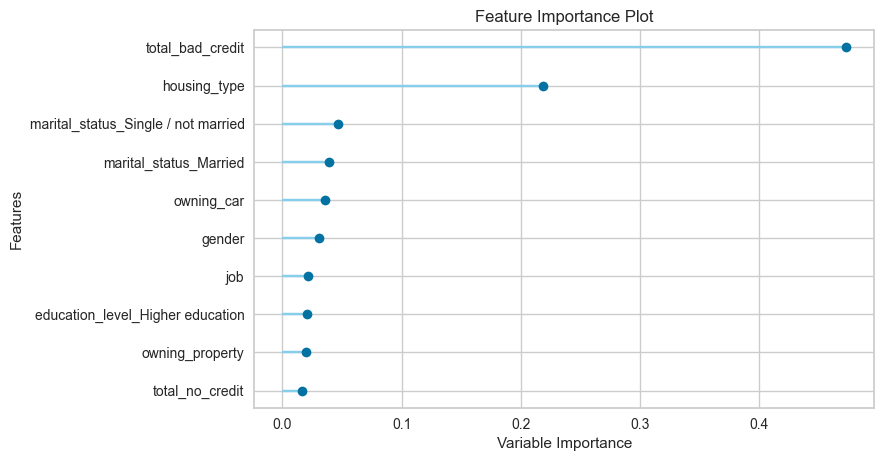

In [15]:
plot_model(best_model_with_oversampling, plot='feature')

In [21]:
#evaluate_model(best_model_with_oversampling)

## Downsamplingansatz




thoerie: Undersampling Methode: Nearmiss

In [22]:
stp_downsampled = pycaret.classification.setup(data = training_data, target = 'risk_user', train_size = 0.8,
            categorical_features = ['gender','owning_car','children_amt', 'owning_property', 'education_level',
                                    'marital_status', 'housing_type', 
                                    'job'],  fold_strategy = 'kfold',
            fix_imbalance = True, fix_imbalance_method = imblearn.under_sampling.NearMiss() , fold = 10,
            ignore_features = ['applicant_ID'])

,Description,Value
0,Session id,5219
1,Target,risk_user
2,Target type,Binary
3,Target mapping,"N: 0, Y: 1"
4,Original data shape,"(20107, 18)"
5,Transformed data shape,"(4120, 28)"
6,Transformed train set shape,"(98, 28)"
7,Transformed test set shape,"(4022, 28)"
8,Ignore features,1
9,Ordinal features,3


In [23]:
best_model_with_downsampling = compare_models(exclude = 'dummy')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.9480,0.9151,0.3921,0.0405,0.0709,0.0659,0.1098,0.4840
xgboost,Extreme Gradient Boosting,0.9417,0.8592,0.4088,0.0398,0.0657,0.0608,0.1023,0.5760
gbc,Gradient Boosting Classifier,0.8494,0.5382,0.2583,0.0044,0.0085,0.0038,0.0156,0.4180
ada,Ada Boost Classifier,0.8113,0.8740,0.7605,0.0389,0.0661,0.0609,0.1245,0.4630
dt,Decision Tree Classifier,0.8094,0.5746,0.3383,0.0046,0.0088,0.0037,0.0201,0.4070
svm,SVM - Linear Kernel,0.7988,0.0000,0.2000,0.0009,0.0019,0.0000,0.0000,0.3830
rf,Random Forest Classifier,0.7358,0.8266,0.8038,0.0111,0.0216,0.0158,0.0708,0.5380
lr,Logistic Regression,0.5127,0.7762,0.9657,0.0096,0.0189,0.0130,0.0628,2.0420
ridge,Ridge Classifier,0.4629,0.0000,0.8005,0.0044,0.0087,0.0027,0.0267,0.3850
lda,Linear Discriminant Analysis,0.4568,0.6975,0.8005,0.0044,0.0087,0.0026,0.0262,0.4030


Processing:   0%|          | 0/45 [00:00<?, ?it/s]

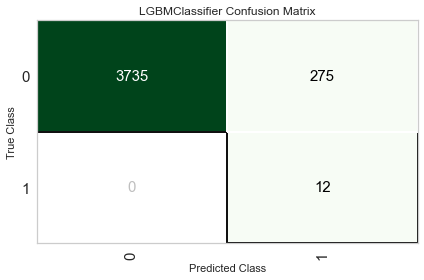

In [24]:
plot_model(best_model_with_downsampling, plot = 'confusion_matrix')

Theorie: Recall, Precision, f1

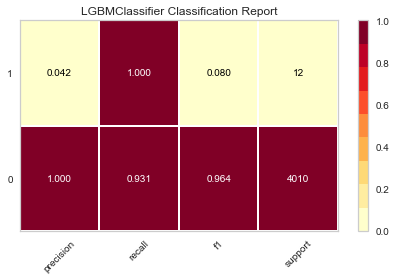

In [27]:
plot_model(best_model_with_downsampling, plot = 'class_report')

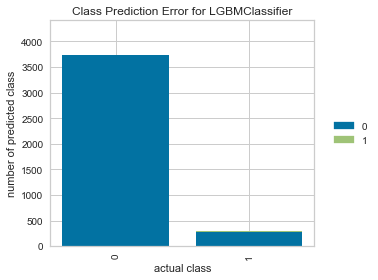

In [29]:
plot_model(best_model_with_downsampling, plot = 'error')

Theorie: Precision/recall Kurve

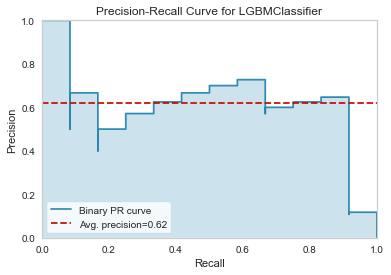

In [32]:
plot_model(best_model_with_downsampling, plot = 'pr')

theorie: Learning curve.

Notiz: generell sieht man hier, das das Model anfang erst underfittet bzw unfähig ist mit der Komplesitöt im Datensatz klarzukommen.

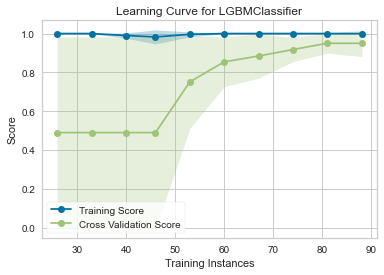

In [34]:
plot_model(best_model_with_downsampling, plot = 'learning')

Diese Methode gibt uns zwar fehler type 1? 
aber ist besser als wenn man FN zurückgibt, in dem Fall würde es bedeuten, dass Creditcard approved werden, obwohl ein hohes Risiko dargestellt

## Anderer Ansatz

In [18]:
#Separieren von Minority und Mijority Klassen
#dummy_risk_user = training_data[training_data.risk_user == 'Y']
#dummy_non_risk_user = training_data[training_data.risk_user == 'N']
#

# am besten werden random Instanzen gelöscht, die keine bestimmte Kriterien befolgen
# attention: Mit jede Ausführung werden andere Obersavationen gelöscht
#indices_top_drop = default_rng().choice(dummy_non_risk_user.index, size=426966, replace=False)
#non_risk_user_reduced = dummy_non_risk_user.drop(index=indices_top_drop)

#reduced_number_non_risk_user = sum(non_risk_user_reduced['risk_user'] == 'N')
#number_risk_user = sum(dummy_risk_user['risk_user'] == 'Y')
#print("Non risk users are now randomly reduced to", reduced_number_non_risk_user )
#print("Risk users are ", number_risk_user)

# Joining die manuell downsampelt datasets zusammen
#resampled_df = pd.concat([non_risk_user_reduced, dummy_risk_user], ignore_index=True)
#resampled_df.count()

Es ist auffällig, wie die Accuracy von den vorgeschlagenen Modellen sowohl mithilfe von Oversampling als auch downsampling aus Pycaret so hoch ist. Das ist vielleicht ein Zeichen. In diesem Abschnitt möchten wir einen anderen Ansatz wählen, um zu überprüfen, ob die Ergebnisse aus den vorherigen Experiemente vertraucenwürdig sind.



## Literaturverzeichnis

- [1] https://pestleanalysis.com/descriptive-analysis/#What_Is_Descriptive_Analysis
- [2] https://machinelearningmastery.com/what-is-imbalanced-classification/
- [3] https://imbalanced-learn.org/stable/references/generated/imblearn.under_sampling.NearMiss.html
